## Advanced Lane Finding  Project 
#### The goals / steps of this project are the following:


* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob

import pickle

# Helper fundtions for image processing & lane finding
import imageHelper as imgHelper
import laneHelper

## Compute the camera calibration using chessboard images

In [15]:
# show images in standalone windows
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                      
        cv2.imshow('img',img)
        cv2.waitKey(500)
                
        ## temp output only ##
        out_file = 'output_images/cali_out' + str(i) + '.jpg'
        cv2.imwrite(out_file, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        ## End temp output ##

cv2.destroyAllWindows()

# Calculate camera matrix and distortion coefficients
img_size = (1280, 720)  # all images are of the same size, hard coded
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

## Start from the following cell afterwards once above done 

In [47]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


# prepare data to be used for all processes
src = np.float32([[580, 460], [700, 460], [1096, 720], [200, 720]])
dst = np.float32([[300, 0], [950, 0], [950, 720], [300, 720]])
src_x, src_y =  [each[0] for each in src]+[580.], [each[1] for each in src]+[460.]
dst_x, dst_y =  [each[0] for each in dst]+[300.], [each[1] for each in dst]+[0]

apex = (640, 400)
imshape = (720, 1280)
vertices = np.array([[(0,imshape[0]),
                      (apex[0]-30, apex[1]), 
                      (apex[0]+30, apex[1]), 
                      (imshape[1],imshape[0])
                    ]], dtype=np.int32)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension   30/720
xm_per_pix = 4/700 # meters per pixel in x dimension    3.7/700

## Build a Lane Finding Pipeline  

1. Apply a distortion correction to raw images.
2. Use color transforms, gradients, etc., to create a thresholded binary image.
3. Apply a perspective transform to rectify binary image ("birds-eye view").
4. Detect lane pixels and fit to find the lane boundary.
5. Determine the curvature of the lane and vehicle position with respect to center.
6. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries w/ estimation of lane curvature and vehicle position

## Pipeline function to process image 

In [48]:
def process_image(image):
    """
    # image: a color image (3 channel) for processing video belowe
    # return: the final output (image )
    """
    
    
    """ STEP 1 Apply a distortion correction  """
    undist = imgHelper.cal_undistort(image, mtx, dist)
    
    """ STEP 2 Create a gradient/color thresholded binary image """
    #  x gradient threshold sobel_thresh=(30, 100) R/S channel threshold r_thresh=(180,255), s_thresh=(170, 255)    
    combo_binary = imgHelper.combined_binary(image, sobel_thresh=(30, 100), r_thresh=(180,255), s_thresh=(170, 255))
    ROI_binary = imgHelper.region_of_interest(combo_binary, vertices)
         
    """ STEP 3 Apply perspective transform to get birds-eye view """ 
    binary_warped = imgHelper.warper(combo_binary, src, dst)
    
    """ STEP 4 Detect lane pixels and fit to find the lane boundary """
    # Find our lane pixels first by sliding window & fit polynomial values
    leftx, lefty, rightx, righty, out_img = laneHelper.find_lane_pixels_byWin(binary_warped)
    fits, fitxs, ploty = laneHelper.fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
     
    ### for temp Visulization only ###
    # histogram to show starting points for sliding window
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) 
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]
      
    # Plots the left and right polynomials on the lane lines
    #plt.plot(fitxs[0], ploty, color='yellow')
    #plt.plot(fitxs[1], ploty, color='yellow')
    #plt.imshow(out_img)
    ###  End temp visuilizaiton ###
           
    """ STEP 5 Determine the curvature of the lane and vehicle position """
    left_cr, right_cr = laneHelper.measure_curvature_real(fitxs, ploty, ym_per_pix, xm_per_pix)
    avg_cr = (left_cr + right_cr)//2
 
    """ STEP 6 Warp the detected lane boundaries back onto the original image image """
    color_warp = laneHelper.draw_lines(binary_warped, fitxs, ploty)
   
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = imgHelper.warper(color_warp, dst, src) 
    # Combine the result with the original image
    combo_weighted = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
       
    """ STEP 7 Output visual display """
    
    # show info about curvature and car offset
    show_info = laneHelper.get_info(fitxs[0][0], fitxs[1][0], imshape, xm_per_pix, avg_cr)
    
    font = cv2.FONT_HERSHEY_SIMPLEX  # font
    cv2.putText(combo_weighted, show_info[0], (200, 50), font, 1.2, (255, 255, 255), 2)
    cv2.putText(combo_weighted, show_info[1], (200, 100), font, 1.2, (255, 255, 255), 2)
        
    combo_binary = np.dstack((combo_binary, combo_binary, combo_binary))  # for temp visulization only
    result = combo_weighted
     
    return result

## Test a single Image
Test pipeline to work on the images in the directory "test_images" , output copies into the `output_images` directory 

In [49]:
%matplotlib inline
# f, ax = plt.subplots(1, 1, figsize=(8, 5))
# Read in an test image
test_img = cv2.imread('test_images/test6.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

result_img = process_image(test_img)
# plt.plot(result_img)

True

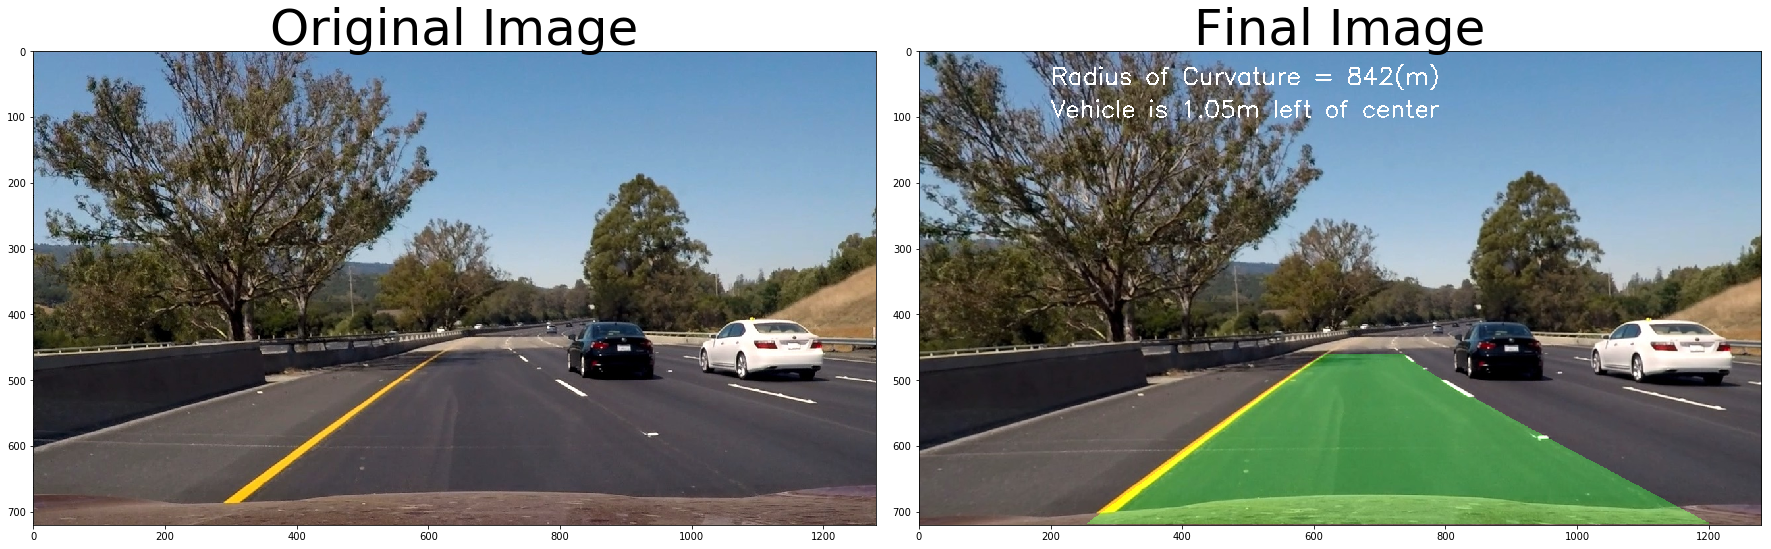

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result_img, cmap='gray')
ax2.set_title('Final Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# write image 
out_file = 'output_images/test_out.jpg'
cv2.imwrite(out_file, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))

True

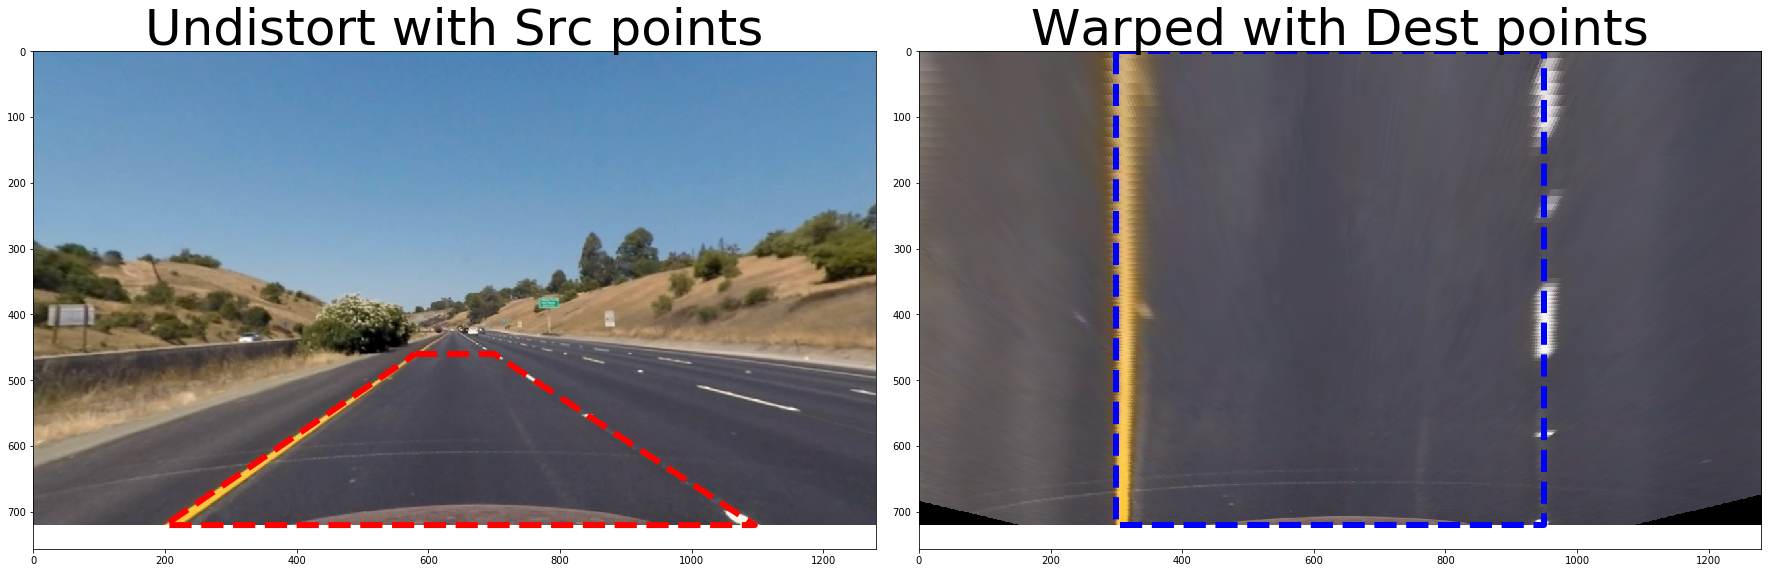

In [44]:
test_img = imgHelper.cal_undistort(test_img, mtx, dist)
result_img = imgHelper.warper(test_img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Undistort with Src points', fontsize=50)
ax2.imshow(result_img, cmap='gray')
ax2.set_title('Warped with Dest points', fontsize=50)

ax1.plot(src_x, src_y, 'r--', lw=6)
ax2.plot(dst_x, dst_y, 'b--', lw=6)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# write image 
out_file = 'output_images/test_out.jpg'
cv2.imwrite(out_file, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))

True

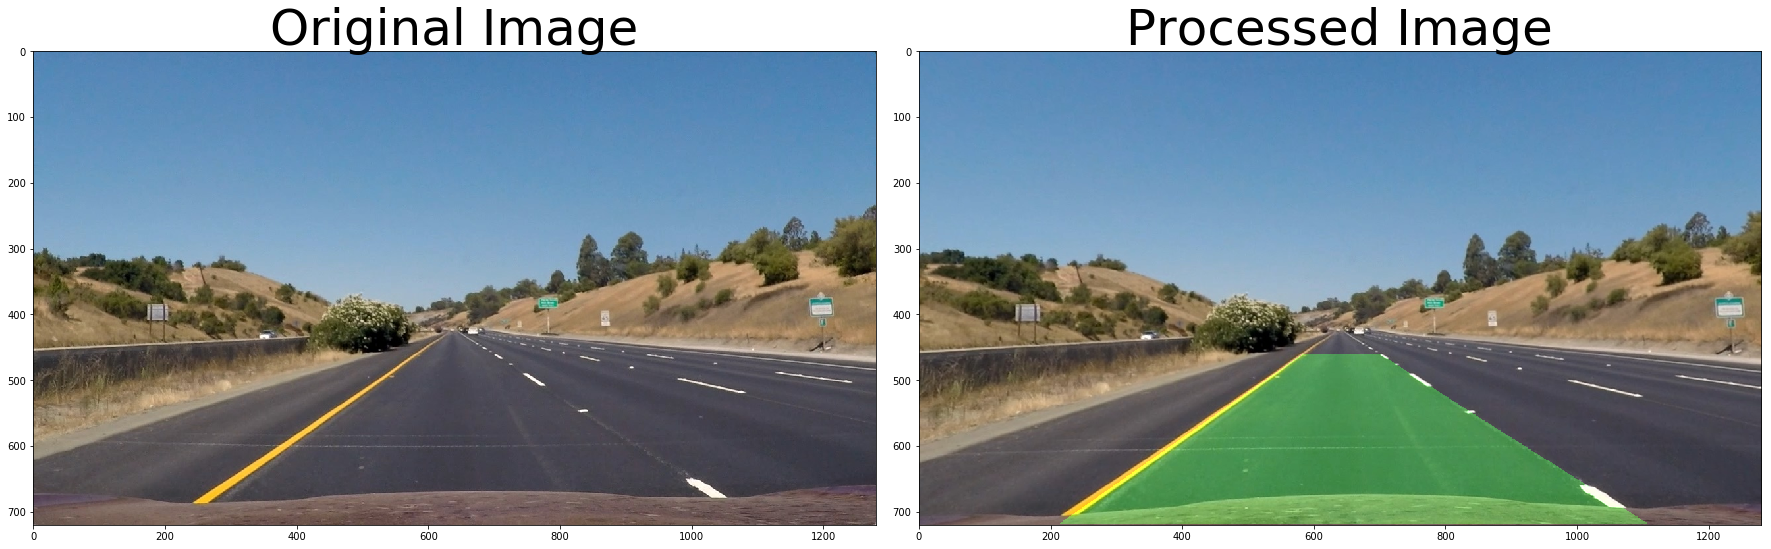

In [8]:
## warp back onto original 

True

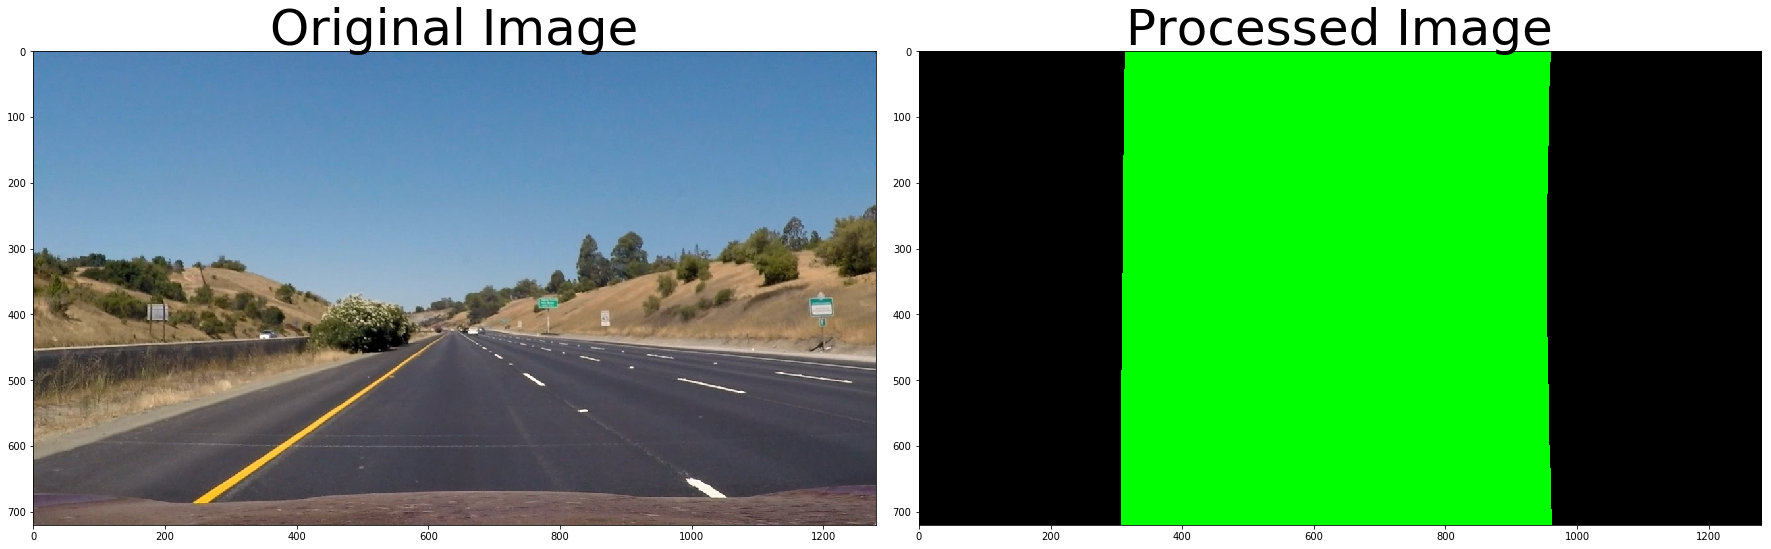

In [21]:
## color warp

True

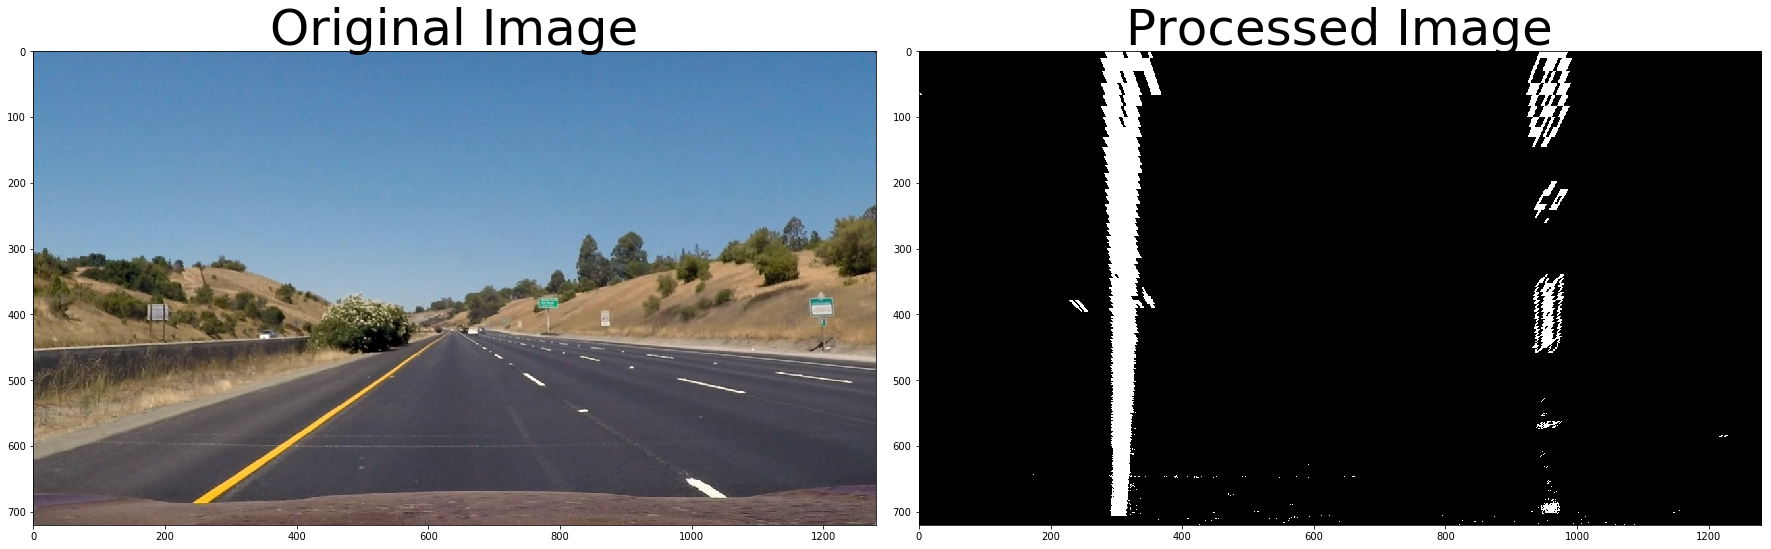

In [19]:
## binary warped - perspective transformed

True

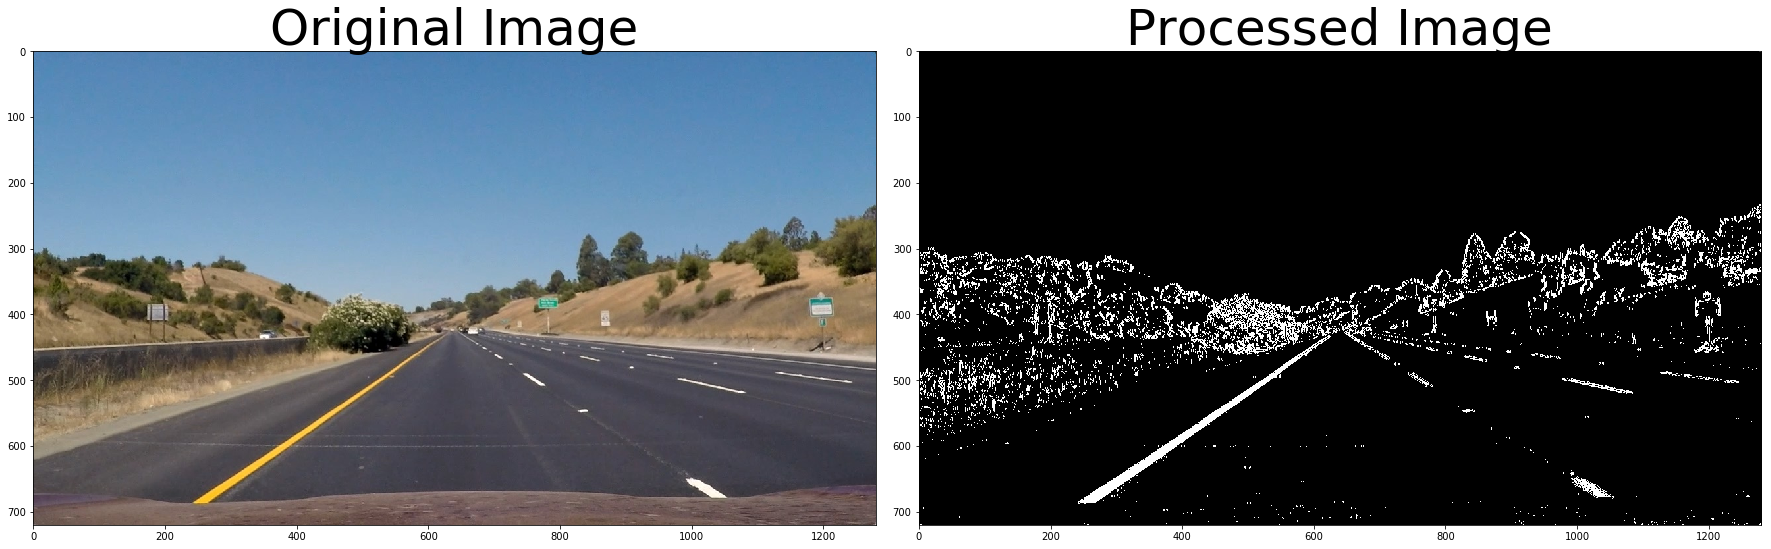

In [17]:
## binary output

True

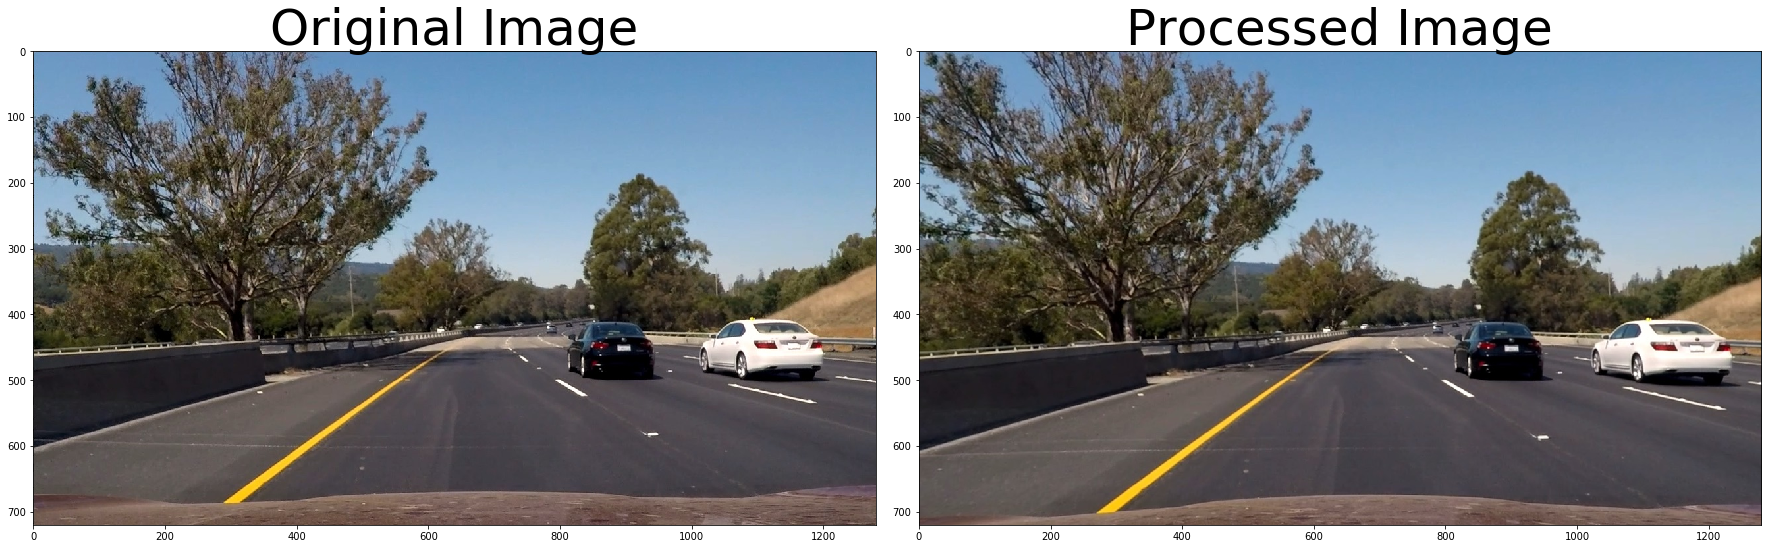

In [6]:
## undistort test image

True

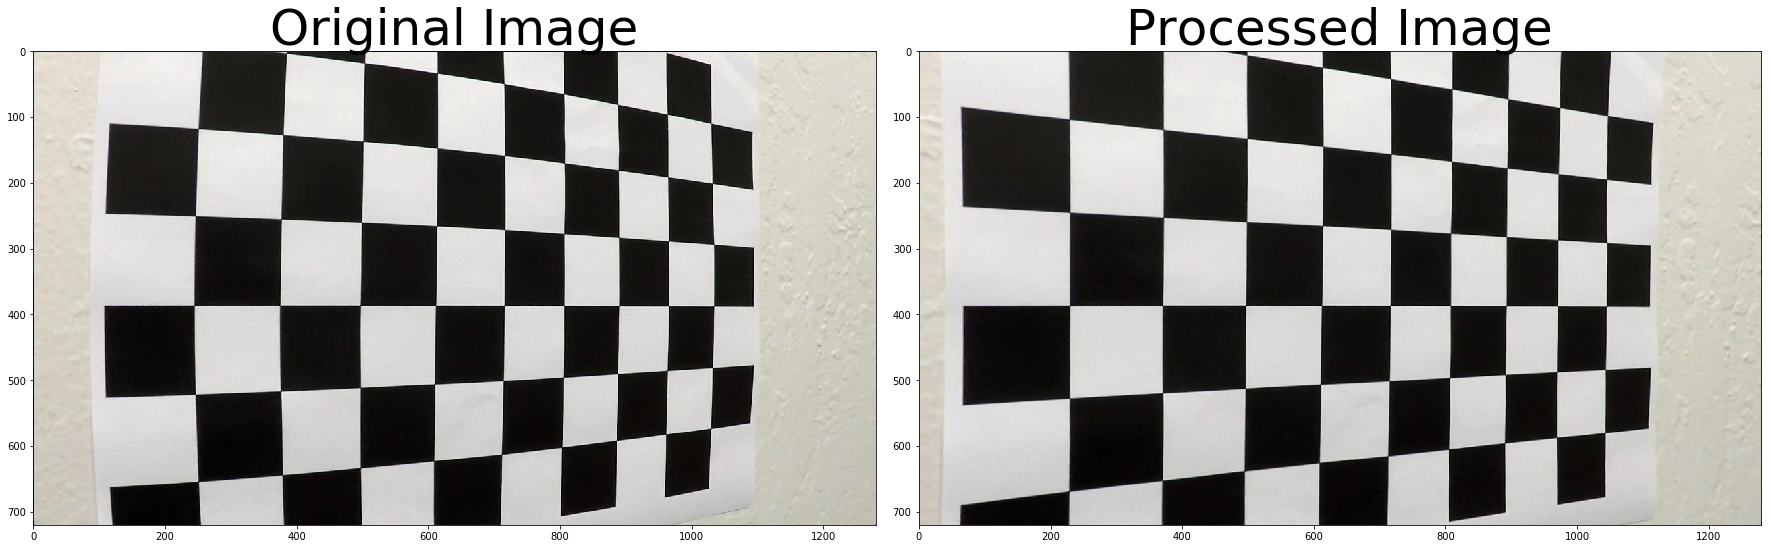

In [13]:
## undistort chessboard

## Test Images

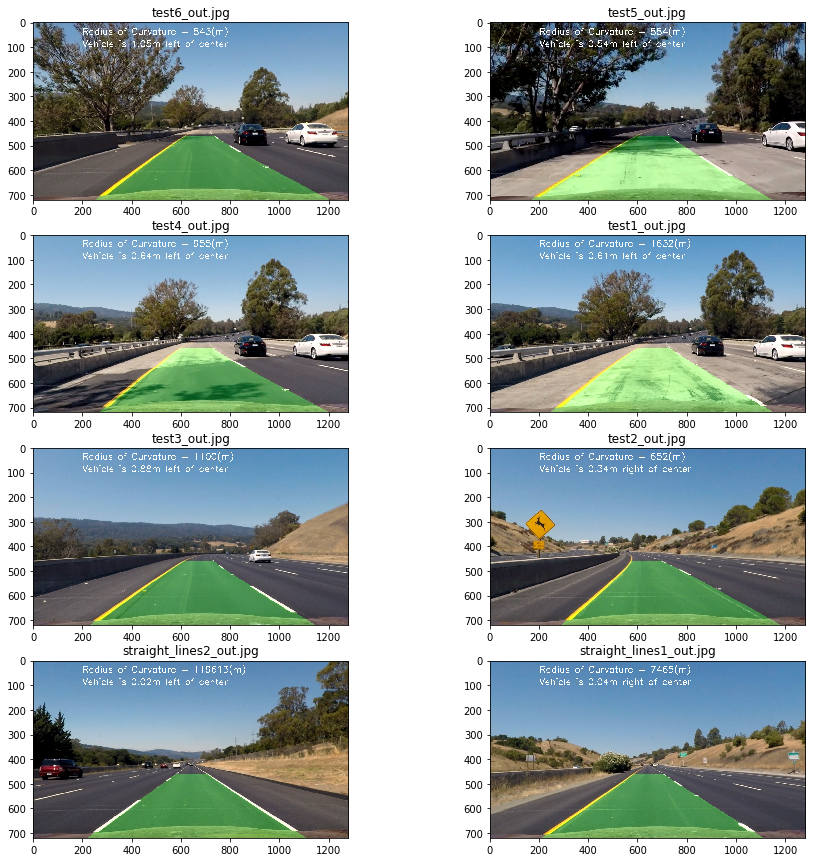

In [51]:
import os
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
test_dir = 'test_images/'
test_dir_out = 'output_images/'

out_images = []

# loop to read & process images
for img_file in os.listdir(test_dir):
    image = mpimg.imread(test_dir + img_file)
    
    # process image to find lane lines
    result_img = process_image(image)
    
    # write image 
    out_file = test_dir_out + img_file.split('.')[0] + '_out.jpg'       
    cv2.imwrite(out_file, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
    
    out_images.append(out_file)

_, axes = plt.subplots(4,2, figsize=(15, 15))
for i, ax in enumerate(axes.flatten()): 
    #print(out_images[i].split('/')[1])    
    image = mpimg.imread(out_images[i])
    ax.imshow(image, cmap='gray')
    ax.set_title(out_images[i].split('/')[1])


## Test on Videos
Drawing lanes over video! `project_video.mp4`

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
video_output = 'Adv_out_video.mp4'
## add .subclip(start_second,end_second) 
## Where start_second and end_second are integer values representing the start and end of the subclip
clip = VideoFileClip("project_video.mp4")
#clip = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:25, 14.74it/s, now=None]

Moviepy - Building video Adv_out_video.mp4.
Moviepy - Writing video Adv_out_video.mp4



Moviepy - Done !
Moviepy - video ready Adv_out_video.mp4
CPU times: user 2min 34s, sys: 38 s, total: 3min 12s
Wall time: 2min 53s


Play the video inline

In [44]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))